# Replicating Figures from the Paper

Figures to replicate:

1. Batch size schedule tokens saved
2. Phase plot
3. Layernorm is predictive of total GNS? 

### Plot Settings

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # makes a gray plot, which differs from current paper style

### utility functions

In [2]:
def interpolate_loss_series(series1, series2):
    """
    Interpolate between two loss series with different token counts.
    
    Parameters:
    -----------
    series1 : pandas.Series
        First loss series with tokens_processed as index
    series2 : pandas.Series
        Second loss series with tokens_processed as index
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with both series interpolated to all token counts
    """
    # Create a DataFrame with both series
    combined = pd.DataFrame({
        'series1': series1,
        'series2': series2
    })
    
    # Interpolate both series
    combined = combined.interpolate(method='linear', limit_direction='both')
    
    return combined

In [3]:
# this only exists because of a bug that has been fixed
# it doesn't hurt to leave it in though
def read_csv_with_loss_conversion(filepath, **kwargs):
    """
    Read CSV file and automatically convert tensor strings to float values
    for 'train/loss' and 'val/loss' columns.
    
    Parameters:
    -----------
    filepath : str
        Path to CSV file
    **kwargs : dict
        Additional arguments to pass to pd.read_csv
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with converted tensor values in loss columns
    """
    df = pd.read_csv(filepath, **kwargs)
    
    loss_columns = ['train/loss', 'val/loss']
    
    def extract_float(value):
        """Extract float value from tensor string or return original value if not a tensor string"""
        if pd.isna(value):
            return value
        if isinstance(value, (int, float)):
            return value
        if isinstance(value, str) and 'tensor(' in value:
            match = re.search(r'tensor\(([-+]?\d*\.?\d+)\)', value)
            return float(match.group(1)) if match else value
        return value
    
    # Only process the loss columns
    for col in loss_columns:
        if col in df.columns:
            df[col] = df[col].apply(extract_float)
    
    return df

## Loading CSVs

In [4]:
bss_df = read_csv_with_loss_conversion("out-cgpt-openwebtext-bs_schedule/log.csv").set_index("tokens_processed")
base_df = read_csv_with_loss_conversion("out-cgpt-openwebtext/log.csv").set_index("tokens_processed")

In [5]:
print(f"{bss_df.shape=} {base_df.shape=}")

bss_df.shape=(18954, 137) base_df.shape=(9035, 383)


## Batch Size Schedule

In [6]:
s = []
for n, df in [('bss', bss_df), ('base', base_df)]:
    series = df['val/loss']
    s.append(series.dropna())
loss_df = interpolate_loss_series(*s)

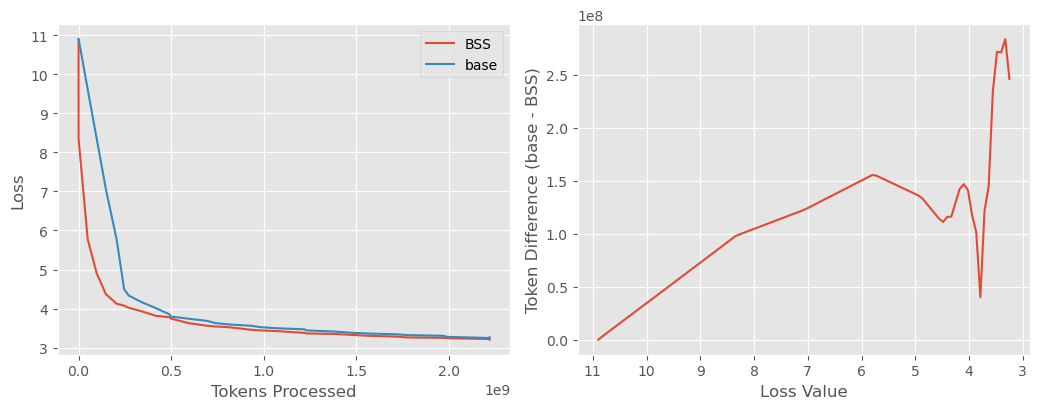

In [7]:
def plot_loss_comparison(series1, series2, series1_name, series2_name):
    """
    Create a side-by-side plot comparing two loss series:
    1. Loss vs tokens processed
    2. Token difference at equivalent loss values
    
    Parameters:
    -----------
    series1, series2 : pandas.Series
        Loss series with tokens_processed as index
    series1_name, series2_name : str
        Names of the series for the legend
    """
    # Interpolate series
    combined = pd.DataFrame({
        series1_name: series1,
        series2_name: series2
    })
    combined = combined.interpolate(method='linear', limit_direction='both')
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(0.7*15, 0.7*6))
    
    # Left plot: Loss vs tokens
    ax1.plot(combined.index, combined[series1_name], label=series1_name)
    ax1.plot(combined.index, combined[series2_name], label=series2_name)
    ax1.set_xlabel('Tokens Processed')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Calculate token difference at each loss value
    min_loss = max(combined[series1_name].min(), combined[series2_name].min())
    max_loss = min(combined[series1_name].max(), combined[series2_name].max())
    
    # Create interpolation functions to find tokens at each loss value
    loss_points = np.linspace(min_loss, max_loss, 100)
    tokens1 = np.interp(loss_points, 
                       combined[series1_name][::-1], 
                       combined.index[::-1])
    tokens2 = np.interp(loss_points, 
                       combined[series2_name][::-1], 
                       combined.index[::-1])
    
    # Plot token difference vs loss
    token_diff = tokens2 - tokens1
    ax2.plot(loss_points, token_diff)
    ax2.set_xlabel('Loss Value')
    ax2.set_ylabel(f'Token Difference ({series2_name} - {series1_name})')
    ax2.grid(True)
    ax2.invert_xaxis()
    
    # Adjust layout and display
    plt.tight_layout()
    return fig

_ = plot_loss_comparison(loss_df['series1'], loss_df['series2'], 'BSS', 'base')

## GNS Analysis

This does the same thing as the `gns-analysis.py` script but it uses matplotlib instead of plotille.

In [8]:
bss_df = read_csv_with_loss_conversion("out-cgpt-openwebtext-bs_schedule/log.csv")
base_df = read_csv_with_loss_conversion("out-cgpt-openwebtext/log.csv")

In [9]:
def analyze_gns_metrics(df, alpha=0.95, prefix='train/gns', x_axis='step'):
    """Analyze GNS metrics using pandas."""
    # Helper function for unbiased stats
    def unbiased_stats(sgn, spegn, b):
        gtg = (b * sgn - spegn) / (b - 1.)
        trsigma = (spegn - sgn) / (1. - (1. / b))
        return gtg, trsigma
    
    # Get aligned columns for GNS metrics
    def get_aligned_columns(df, prefix='train/gns'):
        # Get all columns that start with the prefix
        prefix_cols = [col for col in df.columns if col.startswith(prefix)]
        
        # Organize columns by parameter name and type
        param_data = {}
        for col in prefix_cols:
            parts = col.split('/')
            if len(parts) < 3:  # Ensure we have prefix/param/metric
                continue
            
            param_name = parts[-2]  # Get parameter name
            metric_type = parts[-1]  # Get metric type (norm, pegn, batch_size)
            
            if param_name not in param_data:
                param_data[param_name] = {}
            param_data[param_name][metric_type] = col
        
        # Verify we have complete data for each parameter
        valid_params = []
        for param, metrics in param_data.items():
            if any(s in param for s in ['wte', 'lm_head']):
                continue # skip tied weights
            if all(metric in metrics for metric in ['norm', 'pegn', 'batch_size']):
                valid_params.append(param)
        
        # Sort parameters by name for consistent ordering
        valid_params.sort()
        
        # Create aligned lists of column names
        norm_cols = [param_data[param]['norm'] for param in valid_params]
        pegn_cols = [param_data[param]['pegn'] for param in valid_params]
        batch_size_cols = [param_data[param]['batch_size'] for param in valid_params]
        
        return norm_cols, pegn_cols, batch_size_cols, valid_params

    # Get aligned columns
    norm_cols, pegn_cols, batch_size_cols, param_names = get_aligned_columns(df, prefix)
    
    if not norm_cols:
        raise ValueError(f"No valid columns found with prefix {prefix}")
    
    # Verify consistent batch size per step
    batch_sizes = df[batch_size_cols].nunique(axis=1)
    if not (batch_sizes == 1).all():
        raise ValueError("Inconsistent batch sizes found within steps")
    
    # Use the first batch size column (they should all be the same)
    batch_size = df[batch_size_cols[0]]
    
    # Square the norms and sum across parameters
    total_sgn = df[norm_cols].pow(2).sum(axis=1)
    total_spegn = df[pegn_cols].pow(2).sum(axis=1)

    # Convert to numpy arrays for vectorized computation
    sgn = total_sgn.to_numpy()
    spegn = total_spegn.to_numpy()
    b = batch_size.to_numpy()
    
    # Vectorized computation of gtg and trsigma
    gtg = (b * sgn - spegn) / (b - 1.)
    trsigma = (spegn - sgn) / (1. - (1. / b))

    # Clamp to safe range to deal with loss spikes
    gtg = np.clip(gtg, 1e-4, None)
    trsigma = np.clip(trsigma, 1e-4, None)
    
    # Create results dataframe
    results = pd.DataFrame({
        'step': df[x_axis],
        'batch_size': batch_size,
        'gtg': gtg,
        'trsigma': trsigma,
    })

    # Compute EMAs
    results['gtg_ema'] = results['gtg'].ewm(alpha=1-alpha, adjust=False).mean()
    results['trsigma_ema'] = results['trsigma'].ewm(alpha=1-alpha, adjust=False).mean()
    
    # Compute GNS
    results['gns'] = results['trsigma_ema'] / results['gtg_ema'].clip(lower=1e-6)
    
    # Add raw norms
    results['sgn'] = total_sgn
    results['spegn'] = total_spegn
    
    return results

In [10]:
# Analyze both datasets
x_axis = 'tokens_processed'
alpha = 0.99
bss_results = analyze_gns_metrics(bss_df, alpha=alpha, x_axis=x_axis)
base_results = analyze_gns_metrics(base_df, alpha=alpha, x_axis=x_axis)

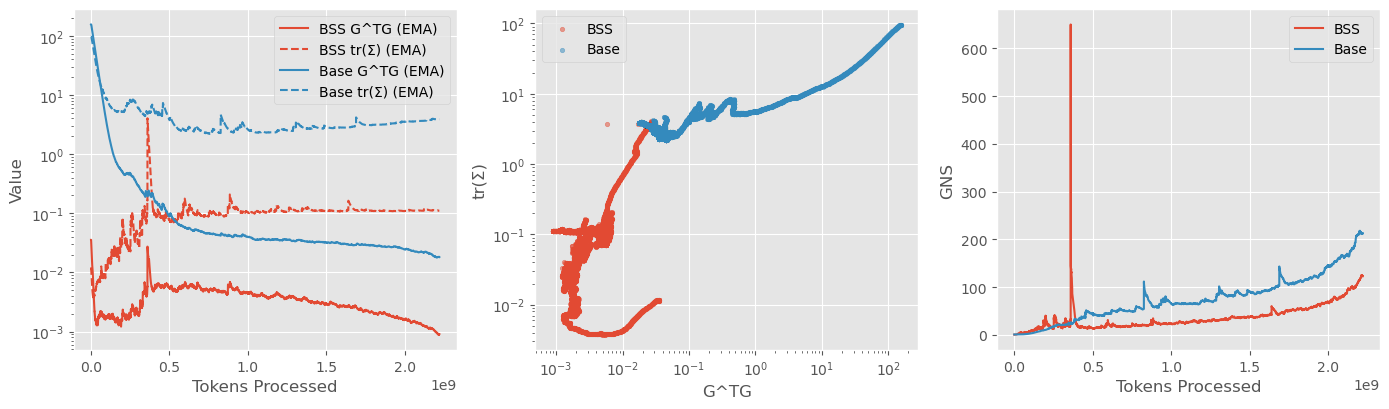

In [11]:
# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(0.7*20, 0.7*6))

# Prepare x label
x_label = {'step':'Steps', 'tokens_processed':'Tokens Processed'}[x_axis]

# Plot 1: Trace and G^TG over tokens for both models
ax1.plot(bss_results['step'], bss_results['gtg_ema'], label='BSS G^TG (EMA)', color='C0')
ax1.plot(bss_results['step'], bss_results['trsigma_ema'], label='BSS tr(Σ) (EMA)', color='C0', linestyle='--')
ax1.plot(base_results['step'], base_results['gtg_ema'], label='Base G^TG (EMA)', color='C1')
ax1.plot(base_results['step'], base_results['trsigma_ema'], label='Base tr(Σ) (EMA)', color='C1', linestyle='--')
ax1.set_xlabel(x_label)
ax1.set_ylabel('Value')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plot 2: Phase plots
ax2.scatter(bss_results['gtg_ema'], bss_results['trsigma_ema'], 
           label='BSS', alpha=0.5, s=10)
ax2.scatter(base_results['gtg_ema'], base_results['trsigma_ema'], 
           label='Base', alpha=0.5, s=10)
ax2.set_xlabel('G^TG')
ax2.set_ylabel('tr(Σ)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

# Plot 3: GNS over steps
ax3.plot(bss_results['step'], bss_results['gns'], label='BSS')
ax3.plot(base_results['step'], base_results['gns'], label='Base')
ax3.set_xlabel(x_label)
ax3.set_ylabel('GNS')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Print summary statistics
print("\nGNS Analysis Results:")
print("=====================")
print(f"BSS Final GNS: {bss_results['gns'].iloc[-1]:.4f}")
print(f"BSS Final G^TG (EMA): {bss_results['gtg_ema'].iloc[-1]:.4f}")
print(f"BSS Final tr(Σ) (EMA): {bss_results['trsigma_ema'].iloc[-1]:.4f}")
print(f"BSS Average batch size: {bss_results['batch_size'].mean():.1f}")

print(f"\nBase Final GNS: {base_results['gns'].iloc[-1]:.4f}")
print(f"Base Final G^TG (EMA): {base_results['gtg_ema'].iloc[-1]:.4f}")
print(f"Base Final tr(Σ) (EMA): {base_results['trsigma_ema'].iloc[-1]:.4f}")
print(f"Base Average batch size: {base_results['batch_size'].mean():.1f}")


GNS Analysis Results:
BSS Final GNS: 122.2856
BSS Final G^TG (EMA): 0.0009
BSS Final tr(Σ) (EMA): 0.1105
BSS Average batch size: 57.2

Base Final GNS: 213.1733
Base Final G^TG (EMA): 0.0182
Base Final tr(Σ) (EMA): 3.8755
Base Average batch size: 120.0


In [13]:
def get_layer_type(param_key):
    """Get the layer type from a parameter key."""
    parts = param_key.split('/')
    if len(parts) < 3:
        return None
        
    path = parts[2]  # transformer.h.0.attn.c_attn.qkv.weight
    components = path.split('.')
    
    # Special non-layered components
    if 'wte' in path:
        return 'Token Embeddings'
    if 'wpe' in path:
        return 'Position Embeddings'
    if 'ln_f' in path:
        return 'Final LayerNorm'
        
    # Get layer number if it exists
    if 'h.' in path:
        try:
            layer_idx = int(components[components.index('h') + 1])
            return f'Layer {layer_idx}'
        except:
            pass
            
    return 'Other'

def group_params_by_layer(param_keys):
    """Group parameter keys by layer type."""
    layer_types = {}
    for key in param_keys:
        layer_type = get_layer_type(key)
        if not layer_type:
            continue
            
        if layer_type not in layer_types:
            layer_types[layer_type] = []
        layer_types[layer_type].append(key)
    
    return layer_types

In [14]:
def analyze_layerwise_gns(df, alpha=0.95, prefix='train/gns'):
    """Analyze GNS metrics grouped by layer type."""
    
    def unbiased_stats(sgn, spegn, b):
        gtg = (b * sgn - spegn) / (b - 1.)
        trsigma = (spegn - sgn) / (1. - (1. / b))
        return gtg, trsigma
    
    # Get all GNS columns
    param_keys = [k for k in df.keys() if prefix in k]
    
    # Group parameters by layer type
    param_keys = [k for k in bss_df.keys() if 'train/gns' in k]
    layer_groups = group_params_by_layer(param_keys)

    # Process each layer group
    results = {}
    for layer_type, keys in layer_groups.items():
        # Get norm, pegn, and batch_size columns for this layer type
        norm_cols = [k for k in keys if k.endswith('/norm')]
        pegn_cols = [k for k in keys if k.endswith('/pegn')]
        batch_size_cols = [k for k in keys if k.endswith('/batch_size')]
        
        # Skip if we don't have all required metrics
        if not (norm_cols and pegn_cols and batch_size_cols):
            continue
            
        # Verify consistent batch size per step
        batch_sizes = df[batch_size_cols].nunique(axis=1)
        if not (batch_sizes == 1).all():
            continue
            
        # Use the first batch size column
        batch_size = df[batch_size_cols[0]].to_numpy()
        
        # Square and sum the norms across parameters
        total_sgn = df[norm_cols].pow(2).sum(axis=1).to_numpy()
        total_spegn = df[pegn_cols].pow(2).sum(axis=1).to_numpy()
        
        # Compute gtg and trsigma
        gtg, trsigma = unbiased_stats(total_sgn, total_spegn, batch_size)
        
        # Clamp to safe range to deal with loss spikes
        gtg = np.clip(gtg, 1e-6, None)
        trsigma = np.clip(trsigma, 1e-6, None)
            
        # Compute EMAs
        gtg_ema = pd.Series(gtg).ewm(alpha=1-alpha, adjust=False).mean().to_numpy()
        trsigma_ema = pd.Series(trsigma).ewm(alpha=1-alpha, adjust=False).mean().to_numpy()
        
        # Store results
        results[layer_type] = {
            'gtg_ema': gtg_ema,
            'trsigma_ema': trsigma_ema,
            'gns': trsigma_ema / np.clip(gtg_ema, a_min=1e-6, a_max=None)
        }
    
    return results

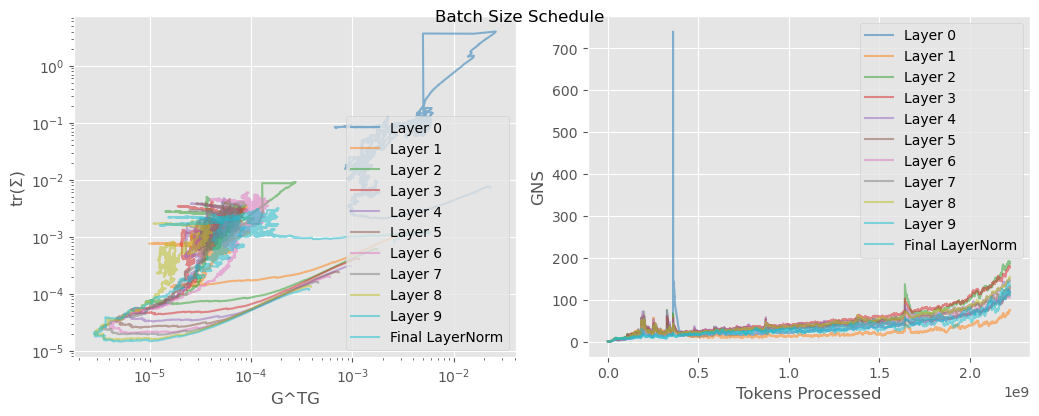

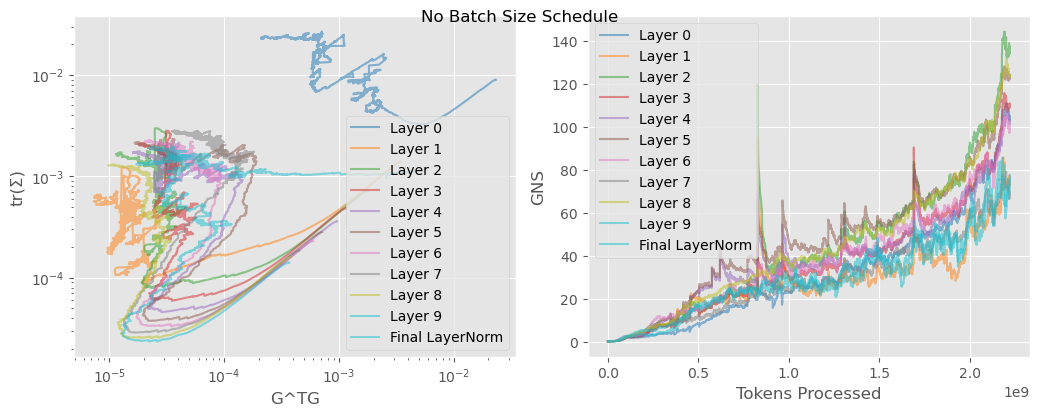

In [15]:
def plot_layerwise_gns(df, alpha=0.99, tokens_col='tokens_processed'):
    """Plot GNS analysis by layer type."""
    results = analyze_layerwise_gns(df, alpha)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(0.7*15, 0.7*6))
    
    # Get list of tokens for x-axis
    tokens = df[tokens_col].to_numpy()
    
    # Color map for consistent colors across plots
    n_layers = len(results)
    colors = plt.cm.tab10(np.linspace(0, 1, n_layers))
    
    # Plot phase plot
    for (layer_type, data), color in zip(results.items(), colors):
        ax1.plot(data['gtg_ema'], data['trsigma_ema'], 
                 label=layer_type, alpha=0.5, color=color)
    
    ax1.set_xlabel('G^TG')
    ax1.set_ylabel('tr(Σ)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)
    
    # Plot GNS over tokens
    for (layer_type, data), color in zip(results.items(), colors):
        ax2.plot(tokens, data['gns'],
                 label=layer_type, alpha=0.5, color=color)
    
    ax2.set_xlabel('Tokens Processed')
    ax2.set_ylabel('GNS')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_layerwise_gns(bss_df)
fig.suptitle('Batch Size Schedule')
plt.show()

# Also plot base model
fig = plot_layerwise_gns(base_df)
fig.suptitle('No Batch Size Schedule')
plt.show()

Separating into layernorm and non-layernorm parameters and plotting the GNS:

In [16]:
def split_layernorm_params(df):
    """Split a DataFrame into layernorm and non-layernorm parameters.
    
    Returns:
        tuple: (layernorm_df, non_layernorm_df) where each contains the columns from the 
        original df plus only the GNS columns for their respective parameter types
    """
    # Get all GNS parameter columns
    param_keys = [k for k in df.keys() if 'train/gns' in k]
    
    # Separate into layernorm and non-layernorm
    ln_keys = [k for k in param_keys if any(x in k for x in ['ln_1', 'ln_2', 'ln_f'])]
    non_ln_keys = [k for k in param_keys if k not in ln_keys]
    
    # Get non-parameter columns
    base_cols = [col for col in df.columns if not col.startswith('train/gns')]
    
    # Create the two dataframes
    ln_df = df[base_cols + ln_keys].copy()
    non_ln_df = df[base_cols + non_ln_keys].copy()
    
    return ln_df, non_ln_df

# Example usage:
ln_df, non_ln_df = split_layernorm_params(base_df)

# Print stats about the split
print("LayerNorm parameters:")
print(f"  {len([c for c in ln_df.columns if c.endswith('/norm')]) } parameters")

print("\nNon-LayerNorm parameters:")
print(f"  {len([c for c in non_ln_df.columns if c.endswith('/norm')]) } parameters")

LayerNorm parameters:
  42 parameters

Non-LayerNorm parameters:
  82 parameters


In [17]:
# Analyze both datasets
x_axis = 'tokens_processed'
alpha = 0.99
ln_results = analyze_gns_metrics(ln_df, alpha=alpha, x_axis=x_axis)
non_ln_results = analyze_gns_metrics(non_ln_df, alpha=alpha, x_axis=x_axis)

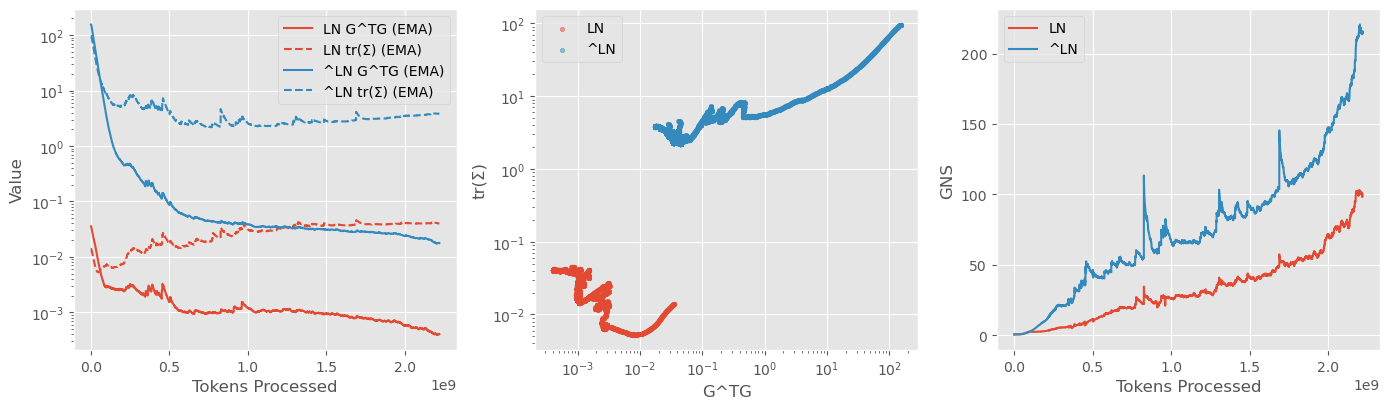

In [18]:
# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(0.7*20, 0.7*6))

# Prepare x label
x_label = {'step':'Steps', 'tokens_processed':'Tokens Processed'}[x_axis]

# Plot 1: Trace and G^TG over tokens for both models
ax1.plot(ln_results['step'], ln_results['gtg_ema'], label='LN G^TG (EMA)', color='C0')
ax1.plot(ln_results['step'], ln_results['trsigma_ema'], label='LN tr(Σ) (EMA)', color='C0', linestyle='--')
ax1.plot(non_ln_results['step'], non_ln_results['gtg_ema'], label='^LN G^TG (EMA)', color='C1')
ax1.plot(non_ln_results['step'], non_ln_results['trsigma_ema'], label='^LN tr(Σ) (EMA)', color='C1', linestyle='--')
ax1.set_xlabel(x_label)
ax1.set_ylabel('Value')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plot 2: Phase plots
ax2.scatter(ln_results['gtg_ema'], ln_results['trsigma_ema'], 
           label='LN', alpha=0.5, s=10)
ax2.scatter(non_ln_results['gtg_ema'], non_ln_results['trsigma_ema'], 
           label='^LN', alpha=0.5, s=10)
ax2.set_xlabel('G^TG')
ax2.set_ylabel('tr(Σ)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

# Plot 3: GNS over steps
ax3.plot(ln_results['step'], ln_results['gns'], label='LN')
ax3.plot(non_ln_results['step'], non_ln_results['gns'], label='^LN')
ax3.set_xlabel(x_label)
ax3.set_ylabel('GNS')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()